In [45]:
import os
import time
import h5py
import pymp
import numpy as np
import pyfftw as ft
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

In [2]:
N = 1024

In [3]:
Q = np.zeros((N,N,N),dtype='float32')
R = np.zeros((N,N,N),dtype='float32')
S2 = np.zeros((N,N,N), dtype='float32')

In [4]:
start = time.time()

nproc = 8
nx = N//nproc

lQ = np.zeros((N//nproc,N,N), dtype='float32')
lR = np.zeros((N//nproc,N,N), dtype='float32')

folder = '/home/jhelsas/scratch'

for k in range(nproc):
    filename = 'ref-Q-'+str(k)+'-(t=0.0).npz'
    files = folder+'/'+filename
    
    content = np.load(files)
    lQ = content['Q']
    
    Q[k*nx:(k+1)*nx,:,:] = lQ[:,:,:]
    
    filename = 'ref-R-'+str(k)+'-(t=0.0).npz'
    files = folder+'/'+filename
    
    content = np.load(files)
    lR = content['R']
    
    R[k*nx:(k+1)*nx,:,:] = lR[:,:,:]
    
end = time.time()
print(end-start)

15.2950329781


In [5]:
start = time.time()

nproc = 8
nx = N//nproc

lS2 = np.zeros((N//nproc,N,N), dtype='float32')

folder = '/home/jhelsas/scratch'

for k in range(nproc):
    filename = 'ref-strainrate-'+str(k)+'.npz'
    files = folder+'/'+filename
    
    content = np.load(files)
    lS2 = content['S2']
    
    S2[k*nx:(k+1)*nx,:,:] = lS2[:,:,:]
    
end = time.time()
print(end-start)

11.1483948231


In [8]:
del lQ,lR,lS2

In [9]:
avg = np.average(S2)
print(avg)

249.219


In [14]:
del S2

In [15]:
Q = Q/avg
R = R/(avg**1.5)

In [17]:
q = Q.flatten()
r = R.flatten()

In [16]:
minJ = -10.0; maxJ =  10.0; E_bins = 100+1
tl = np.linspace(minJ,maxJ,num=E_bins,endpoint=True) 

In [7]:
os.environ['TMPDIR']='/home/jhelsas/scratch'

In [41]:
t1=time.time()

threads = 8
shS = pymp.shared.array((threads,E_bins-1,E_bins-1), dtype='float32')

totL = len(Q)
size = (tl.shape[0]-1)*(tl.shape[0]-1)
dy = dx = tl[1]-tl[0]

chk = q.shape[0]//threads
shS = pymp.shared.array((threads,E_bins-1,E_bins-1), dtype='float32')
with pymp.Parallel(threads) as p:
    for idx in p.range(0,threads):
        jPDF,xedges,yedges=np.histogram2d(q[idx*chk:(idx+1)*chk],r[idx*chk:(idx+1)*chk],bins=(tl,tl),normed=True)
        shS[idx][:] = jPDF[:]

jPDFg = np.zeros((E_bins-1,E_bins-1),dtype='float32')
for idx in range(threads):
    jPDFg[:] += shS[idx][:]
    
jPDFg[:] = jPDFg[:]/threads
    
jPDF=jPDFg/(dx*dy*totL)
gridX,gridY=np.meshgrid(xedges[0:-1]+0.5*dx,yedges[0:-1]+0.5*dy)

t2=time.time()
print('JPDF computation time= %0.2f seconds\n' %(t2-t1))

JPDF computation time= 10.36 seconds



In [42]:
rmin=-10.0;rmax=10.0;qmin=-10.0;qmax=10.0

/home/jhelsas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


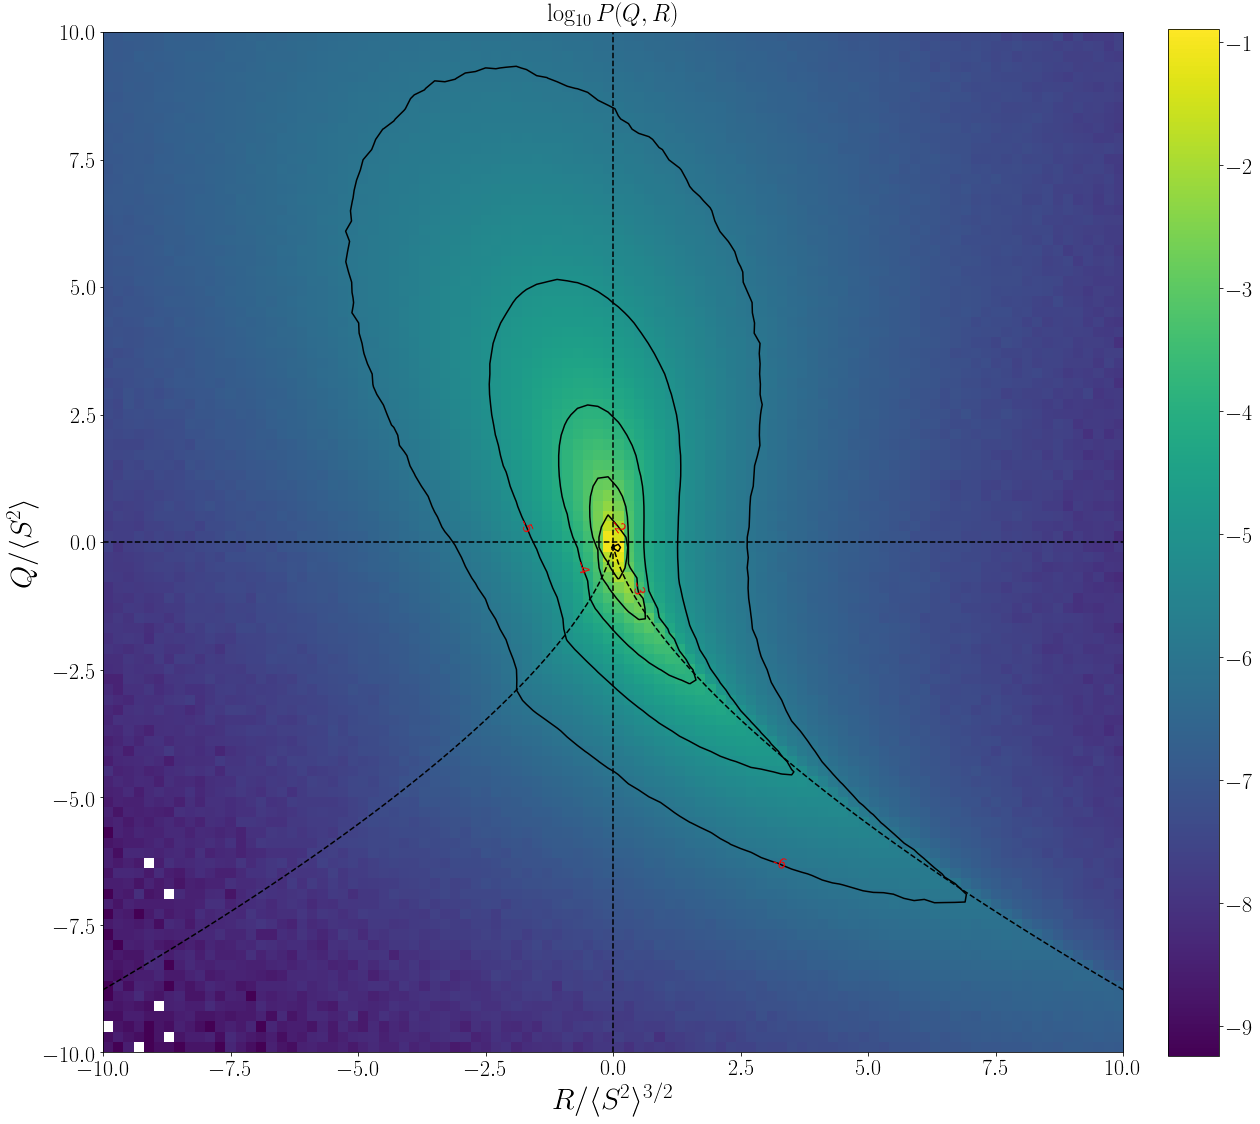

In [46]:
%matplotlib inline

mpl.rcParams['text.usetex'] = True 
fmt={}
fig = plt.figure(figsize=(20,20))
SIZE=20
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE+8)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE+2)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE+2)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)  # legend fontsize

###################################################

Qc=np.linspace(qmin,0,50)
Rc1=-(2./27.)*((-3.*Qc)**1.5)
Rc2=(2./27.)*((-3.*Qc)**1.5)
plt.plot(Rc1,Qc,'--k')
plt.plot(Rc2,Qc,'--k')
plt.plot([0,0],[qmin,qmax],'--k')
plt.plot([rmin,rmax],[0,0],'--k')
plt.axis([rmin,rmax,qmin,qmax])
plt.xlabel(r'$R/\langle S^2\rangle^{3/2}$',fontsize=30)
plt.ylabel(r'$Q/\langle S^2\rangle$',fontsize=30)
plt.title(r'$\log_{10} P({Q,R})$')

###################################################

logjPDF = np.log(jPDF)/np.log(10)

cax = plt.imshow(logjPDF,interpolation='none',extent=(rmin,rmax,qmin,qmax),origin='lower', aspect='equal')
cbar = fig.colorbar(cax,fraction=0.046, pad=0.04)

N = 6
levels=np.logspace(-N,-1,num=N,base=10.0)#np.logspace[1e-5,1e-4,1e-3,1e-2,1e-1]
CS=plt.contour(gridX,gridY,jPDF,levels,colors='k')#[1::2] #extent=(-15,15,-15,15)
strs=['-6','-5','-4','-3','-2','-1']
for l,s in zip(CS.levels,strs):
    fmt[l]=s
plt.clabel(CS,levels,inline=False,fmt=fmt,fontsize=16,colors='r')

#plt.show()
plt.savefig('QR-jpdf-log.pdf', format='pdf', bbox_inches='tight')

In [47]:
dumpfile = "QR-jcorrelation-dims.npz"
content = np.load(dumpfile)
fiits = content['fiits']
E_bins = content['E_bins']
tl = content['tl']

In [48]:
pfiits = np.reshape(fiits,(E_bins-1,E_bins-1)) 
avg = 249.21837

In [49]:
np.set_printoptions(threshold=np.nan)

In [50]:
plotfiits = pfiits+3
plotfiits[plotfiits < 0] = np.nan

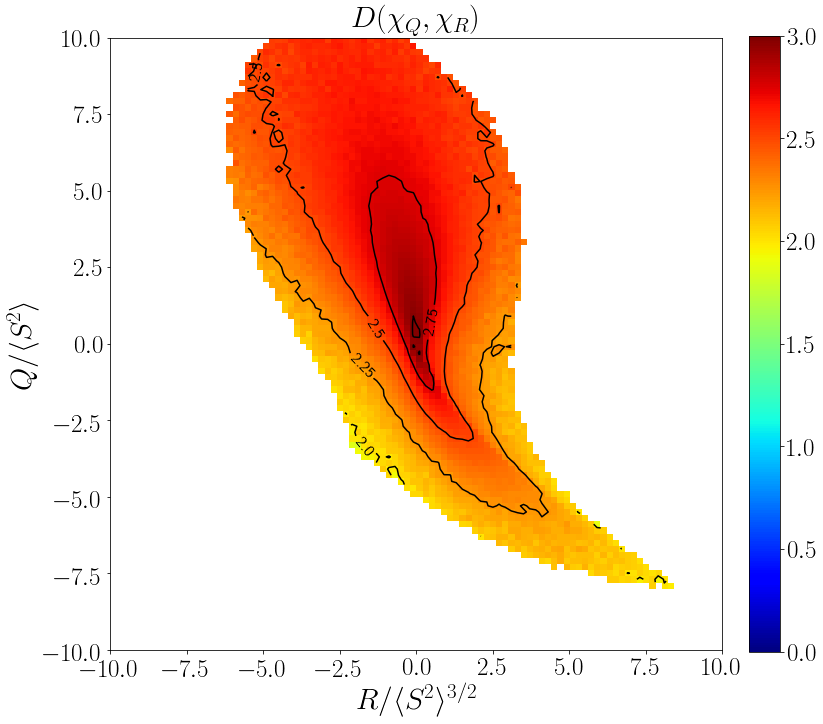

In [60]:
%matplotlib inline 

fig = plt.figure(figsize=(12,12))

SIZE = 25
plt.rcParams['figure.figsize'] = (5, 10)
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
plt.title(r'$D(\chi_Q,\chi_R)$',size=30)
plt.ylabel(r'$ Q/\langle S^2\rangle$',size=30)
plt.xlabel(r'$ R/\langle S^2\rangle^{{3/2}}$',size=30)

rmin = qmin = -10
rmax = qmax = 10

plt.axis([rmin,rmax,qmin,qmax])

cax = plt.imshow(plotfiits,extent=(rmin,rmax,qmin,qmax),interpolation='None',origin='top',aspect='equal', cmap="jet",vmin=0.0,vmax=3.)
cbar = fig.colorbar(cax,fraction=0.046, pad=0.04)

#########################################

fmt={}

levels = np.array([1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,2.97])
CS=plt.contour(gridX,gridY,plotfiits,levels,colors='k')

strs = ['1.0','1.25','1.5','1.75','2.0','2.25','2.5','2.75','2.97']
for l,s in zip(CS.levels,strs):
    fmt[l]=s
plt.clabel(CS,levels,inline=True,fmt=fmt,fontsize=16,colors='k')

#########################################

plt.savefig('QR-joint-dimension-computation-full3.pdf', format='pdf')